In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Cell 2: Cấu hình thông tin kết nối
# !!! QUAN TRỌNG: CẬP NHẬT THÔNG TIN KẾT NỐI CSDL VẬN HÀNH CỦA BẠN !!!
DB_CONFIG_OPERATIONS = {
    "dbname": "Uber_operation_DB",
    "user": "postgres", # << THAY ĐỔI
    "password": "hung12345", # << THAY ĐỔI
    "host": "localhost",
    "port": "5432"
}

In [15]:
DB_CONFIG_CRM = {
    "dbname": "Uber_crm_db",
    "user": "postgres", # << THAY ĐỔI
    "password": "hung12345", # << THAY ĐỔI
    "host": "localhost",
    "port": "5432"
}

In [3]:
sql_query = """
SELECT
    tpep_pickup_datetime::date AS pickup_date,
    COUNT(DISTINCT driver_id) AS unique_drivers
FROM
    trips
WHERE
    tpep_pickup_datetime::date BETWEEN '2023-01-25' AND '2023-01-31'
GROUP BY
    pickup_date
ORDER BY
    pickup_date;
"""

df_report1 = None
conn = None
try:
    print("Đang kết nối đến CSDL Hệ thống Vận hành...")
    conn = psycopg2.connect(**DB_CONFIG_OPERATIONS)
    print("Kết nối thành công. Đang thực thi truy vấn...")
    
    # Sử dụng pandas để đọc kết quả SQL trực tiếp vào DataFrame
    df_report1 = pd.read_sql_query(sql_query, conn)
    
    print("Truy vấn thành công! Dữ liệu đã được tải vào DataFrame.")
    
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")
finally:
    if conn:
        conn.close()
        print("Đã đóng kết nối CSDL.")

Đang kết nối đến CSDL Hệ thống Vận hành...
Kết nối thành công. Đang thực thi truy vấn...


C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_9640\2984958975.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_report1 = pd.read_sql_query(sql_query, conn)


Truy vấn thành công! Dữ liệu đã được tải vào DataFrame.
Đã đóng kết nối CSDL.


In [4]:
if df_report1 is not None:
    display(df_report1.head())

,pickup_date,unique_drivers
0,2023-01-25,57298
1,2023-01-26,58824
2,2023-01-27,58026
3,2023-01-28,58039
4,2023-01-29,50815


In [5]:
# Cell 5: Xử lý và làm giàu dữ liệu
if df_report1 is not None:
    # Đảm bảo cột 'pickup_date' là kiểu datetime
    df_report1['pickup_date'] = pd.to_datetime(df_report1['pickup_date'])
    
    # Tạo một cột mới chứa tên của các thứ trong tuần để biểu đồ dễ đọc hơn
    df_report1['day_of_week'] = df_report1['pickup_date'].dt.day_name()
    
    # Hiển thị lại DataFrame với cột mới
    display(df_report1)

,pickup_date,unique_drivers,day_of_week
0,2023-01-25,57298,Wednesday
1,2023-01-26,58824,Thursday
2,2023-01-27,58026,Friday
3,2023-01-28,58039,Saturday
4,2023-01-29,50815,Sunday
5,2023-01-30,49490,Monday
6,2023-01-31,54667,Tuesday


### Báo cáo 1: Có bao nhiêu tài xế duy nhất hoàn thành ít nhất một chuyến xe mỗi ngày trong tuần qua?

C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_9640\1503210235.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


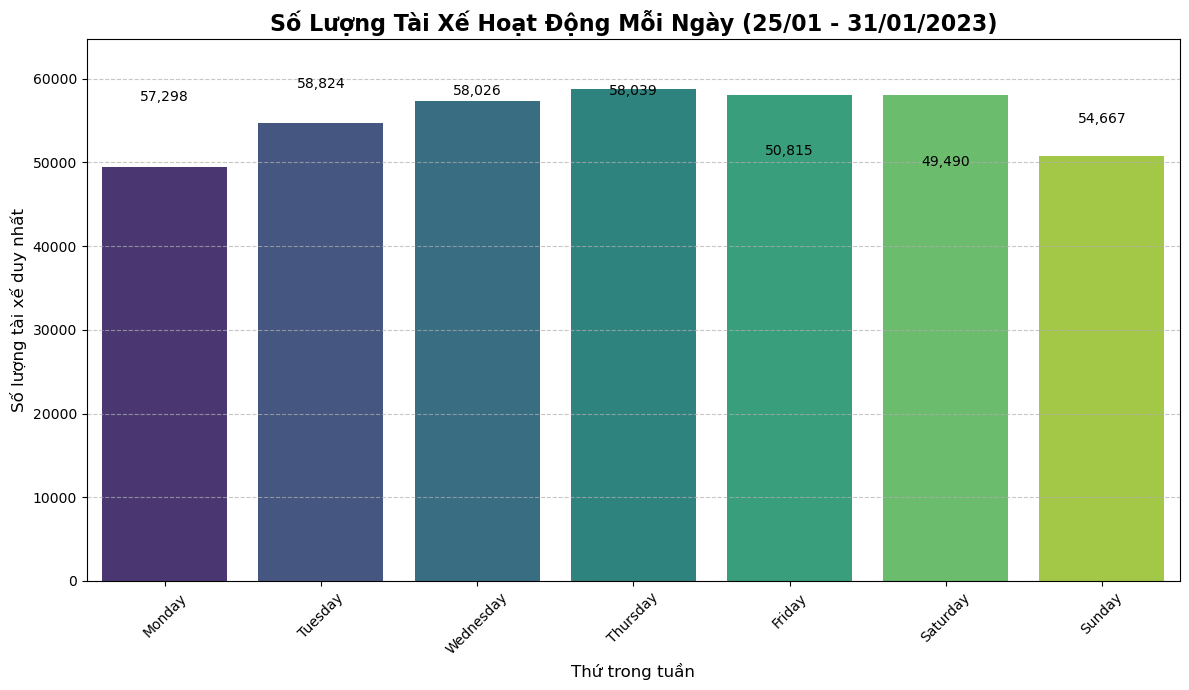

In [6]:
# Cell 6: Vẽ biểu đồ
if df_report1 is not None:
    # Thiết lập kích thước cho biểu đồ
    plt.figure(figsize=(12, 7))
    
    # Sử dụng Seaborn để vẽ biểu đồ cột
    barplot = sns.barplot(
        x='day_of_week', 
        y='unique_drivers', 
        data=df_report1,
        palette='viridis', # Chọn một bảng màu đẹp
        order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # Sắp xếp thứ tự các cột
    )
    
    # Thêm số liệu lên trên mỗi cột để dễ đọc hơn
    for index, row in df_report1.iterrows():
        barplot.text(index, row.unique_drivers + 50, f'{row.unique_drivers:,}', color='black', ha="center", fontsize=10)

    # Thiết lập tiêu đề và các nhãn
    plt.title('Số Lượng Tài Xế Hoạt Động Mỗi Ngày (25/01 - 31/01/2023)', fontsize=16, fontweight='bold')
    plt.xlabel('Thứ trong tuần', fontsize=12)
    plt.ylabel('Số lượng tài xế duy nhất', fontsize=12)
    plt.xticks(rotation=45) # Xoay nhãn trục X để dễ đọc
    plt.ylim(0, df_report1['unique_drivers'].max() * 1.1) # Tăng giới hạn trục Y để có không gian cho số liệu
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Tự động điều chỉnh để không bị xén lề
    
    # Hiển thị biểu đồ
    plt.show()

### Báo cáo 2: Phân bổ số lượng chuyến đi trung bình theo từng giờ trong ngày của tuần qua như thế nào

In [4]:
sql_query_2 = """
SELECT
    EXTRACT(HOUR FROM tpep_pickup_datetime) AS pickup_hour,
    ROUND(COUNT(*) / 7.0, 0) AS average_trips -- Làm tròn đến số nguyên cho dễ nhìn
FROM
    trips
WHERE
    tpep_pickup_datetime::date BETWEEN '2023-01-25' AND '2023-01-31'
GROUP BY
    pickup_hour
ORDER BY
    pickup_hour;
"""

df_report2 = None
conn = None
try:
    print("Đang kết nối lại đến CSDL Hệ thống Vận hành...")
    conn = psycopg2.connect(**DB_CONFIG_OPERATIONS)
    print("Kết nối thành công. Đang thực thi truy vấn cho Báo cáo 2...")
    
    df_report2 = pd.read_sql_query(sql_query_2, conn)
    
    print("Truy vấn thành công! Dữ liệu đã được tải vào DataFrame df_report2.")
    
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")
finally:
    if conn:
        conn.close()
        print("Đã đóng kết nối CSDL.")

Đang kết nối lại đến CSDL Hệ thống Vận hành...
Kết nối thành công. Đang thực thi truy vấn cho Báo cáo 2...


C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_4296\4009635500.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_report2 = pd.read_sql_query(sql_query_2, conn)


Truy vấn thành công! Dữ liệu đã được tải vào DataFrame df_report2.
Đã đóng kết nối CSDL.


In [5]:
if df_report2 is not None:
    # Chuyển kiểu dữ liệu để đảm bảo tính toán đúng
    df_report2['pickup_hour'] = df_report2['pickup_hour'].astype(int)
    df_report2['average_trips'] = df_report2['average_trips'].astype(int)
    display(df_report2.head())

,pickup_hour,average_trips
0,0,2559
1,1,1791
2,2,1273
3,3,789
4,4,495


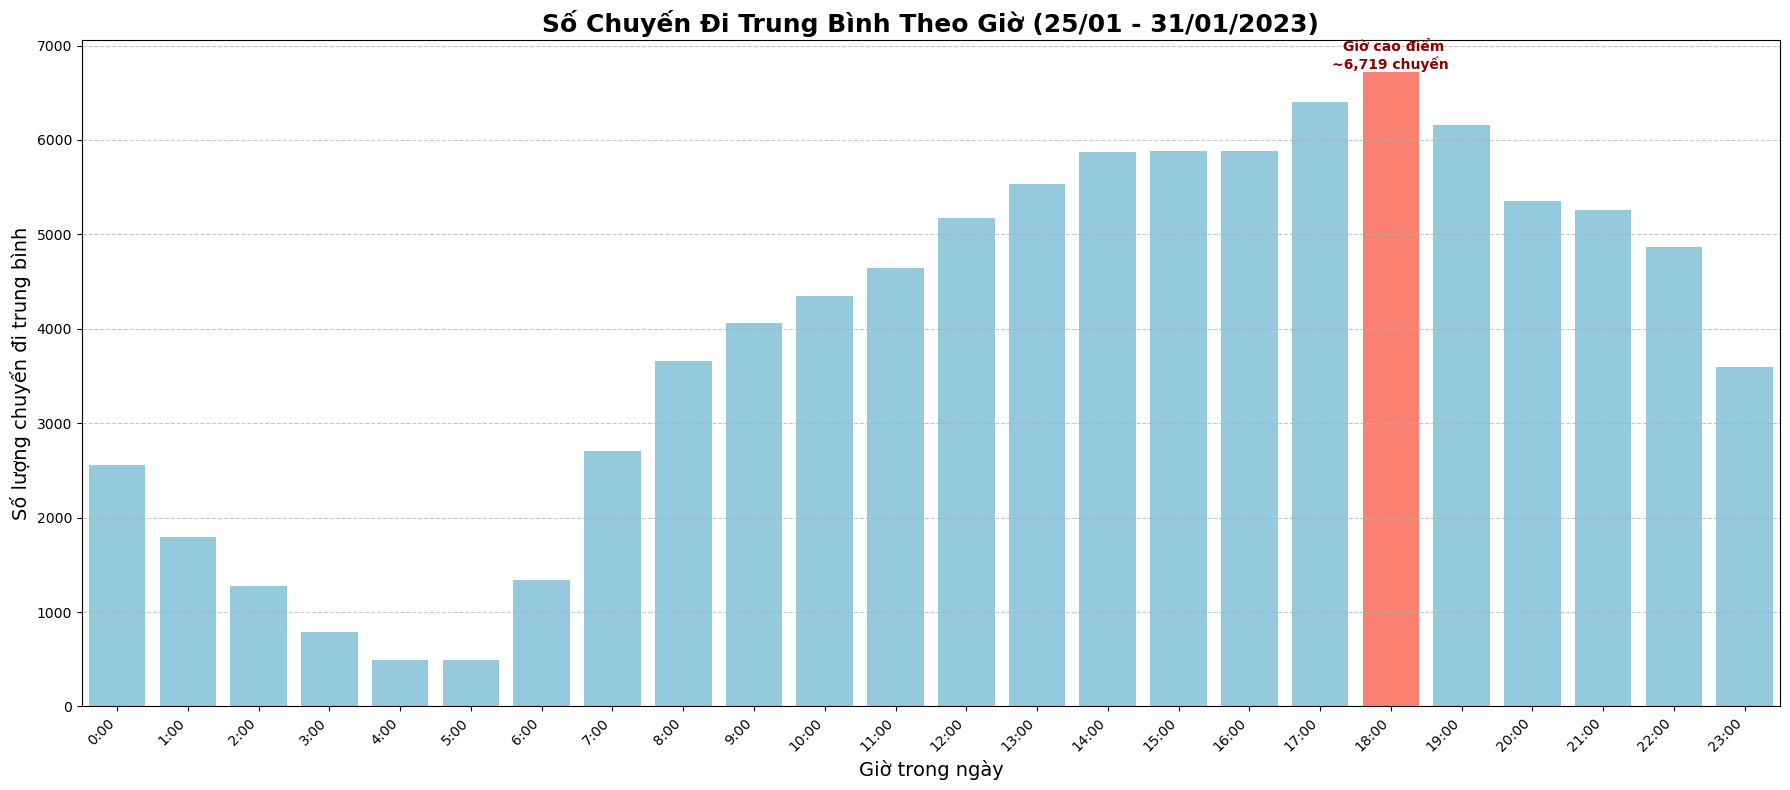

In [6]:
if df_report2 is not None:
    # Thiết lập kích thước cho biểu đồ
    plt.figure(figsize=(18, 8))
    
    # Sử dụng Seaborn để vẽ biểu đồ cột
    barplot = sns.barplot(
        x='pickup_hour', 
        y='average_trips', 
        data=df_report2,
        color='skyblue' # Sử dụng một màu đồng nhất
    )
    
    # Thiết lập tiêu đề và các nhãn
    plt.title('Số Chuyến Đi Trung Bình Theo Giờ (25/01 - 31/01/2023)', fontsize=18, fontweight='bold')
    plt.xlabel('Giờ trong ngày', fontsize=14)
    plt.ylabel('Số lượng chuyến đi trung bình', fontsize=14)
    
    # Đặt nhãn cho trục X là tất cả 24 giờ
    plt.xticks(ticks=range(24), labels=[f'{h}:00' for h in range(24)], rotation=45, ha='right')
    
    # Thêm đường lưới ngang để dễ so sánh
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Tìm và đánh dấu giờ cao điểm
    max_trips = df_report2['average_trips'].max()
    peak_hour = df_report2.loc[df_report2['average_trips'] == max_trips, 'pickup_hour'].iloc[0]
    
    # Tô màu đặc biệt cho cột giờ cao điểm
    barplot.patches[peak_hour].set_facecolor('salmon')
    
    # Thêm chú thích cho giờ cao điểm
    plt.text(peak_hour, max_trips, f' Giờ cao điểm\n~{max_trips:,} chuyến', 
             ha='center', va='bottom', color='darkred', fontweight='bold')

    plt.tight_layout()
    
    # Hiển thị biểu đồ
    plt.show()

### Báo cáo 3: Các khu vực (zone) có số lượng đón khách cao nhất trong tuần qua (25/01/2023 - 31/01/2023) được phân bổ như thế nào trên bản đồ thành phố?

In [7]:
import pandas as pd
import geopandas as gpd
import psycopg2
import matplotlib.pyplot as plt

In [8]:
sql_counts = """
SELECT
    PULocationID AS zone_id,
    COUNT(*) AS pickup_count
FROM
    trips
WHERE
    tpep_pickup_datetime::date BETWEEN '2023-01-25' AND '2023-01-31'
GROUP BY
    PULocationID;
"""

sql_zones = "SELECT zone_id, zone_name, borough, zone_geom FROM taxi_zones;"

conn = None
try:
    print("Đang kết nối đến CSDL Hệ thống Vận hành...")
    conn = psycopg2.connect(**DB_CONFIG_OPERATIONS)
    print("Kết nối thành công.")
    
    # 1. Tải dữ liệu số lượng vào pandas DataFrame
    print("Đang tải dữ liệu số lượng đón khách...")
    df_counts = pd.read_sql_query(sql_counts, conn)
    
    # 2. Tải dữ liệu địa lý vào GeoDataFrame
    # GeoPandas có thể đọc trực tiếp cột GEOMETRY từ PostGIS!
    print("Đang tải dữ liệu hình học các khu vực...")
    gdf_zones = gpd.read_postgis(sql_zones, conn, geom_col='zone_geom')

    print("Tải dữ liệu thành công.")
    
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")
finally:
    if conn:
        conn.close()
        print("Đã đóng kết nối CSDL.")

Đang kết nối đến CSDL Hệ thống Vận hành...
Kết nối thành công.
Đang tải dữ liệu số lượng đón khách...


C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_4296\1083728075.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_counts = pd.read_sql_query(sql_counts, conn)


Đang tải dữ liệu hình học các khu vực...


d:\Anaconda\envs\data_warehouse\Lib\site-packages\geopandas\io\sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


Tải dữ liệu thành công.
Đã đóng kết nối CSDL.


d:\Anaconda\envs\data_warehouse\Lib\site-packages\geopandas\io\sql.py:463: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(spatial_ref_sys_sql, con)


In [9]:
if 'gdf_zones' in locals() and 'df_counts' in locals():
    # Sử dụng left merge để giữ lại tất cả các khu vực trên bản đồ,
    # kể cả những khu vực không có chuyến đi nào trong tuần đó.
    merged_gdf = gdf_zones.merge(df_counts, on='zone_id', how='left')
    
    # Những khu vực không có chuyến đi sẽ có giá trị NaN, ta thay thế chúng bằng 0
    merged_gdf['pickup_count'] = merged_gdf['pickup_count'].fillna(0)
    
    print("Hợp nhất dữ liệu thành công. Dữ liệu sẵn sàng để vẽ bản đồ.")
    display(merged_gdf.head())

Hợp nhất dữ liệu thành công. Dữ liệu sẵn sàng để vẽ bản đồ.


,zone_id,zone_name,borough,zone_geom,pickup_count
0,1,Newark Airport,EWR,"POLYGON ((-74.18563 40.69165, -74.18591 40.691...",8.0
1,3,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.8486 40.87167, -73.84988 40.8721...",7.0
2,18,Bedford Park,Bronx,"POLYGON ((-73.88443 40.8668, -73.88363 40.8672...",12.0
3,20,Belmont,Bronx,"POLYGON ((-73.88392 40.86442, -73.88396 40.864...",4.0
4,31,Bronx Park,Bronx,"POLYGON ((-73.871 40.85728, -73.871 40.85728, ...",1.0


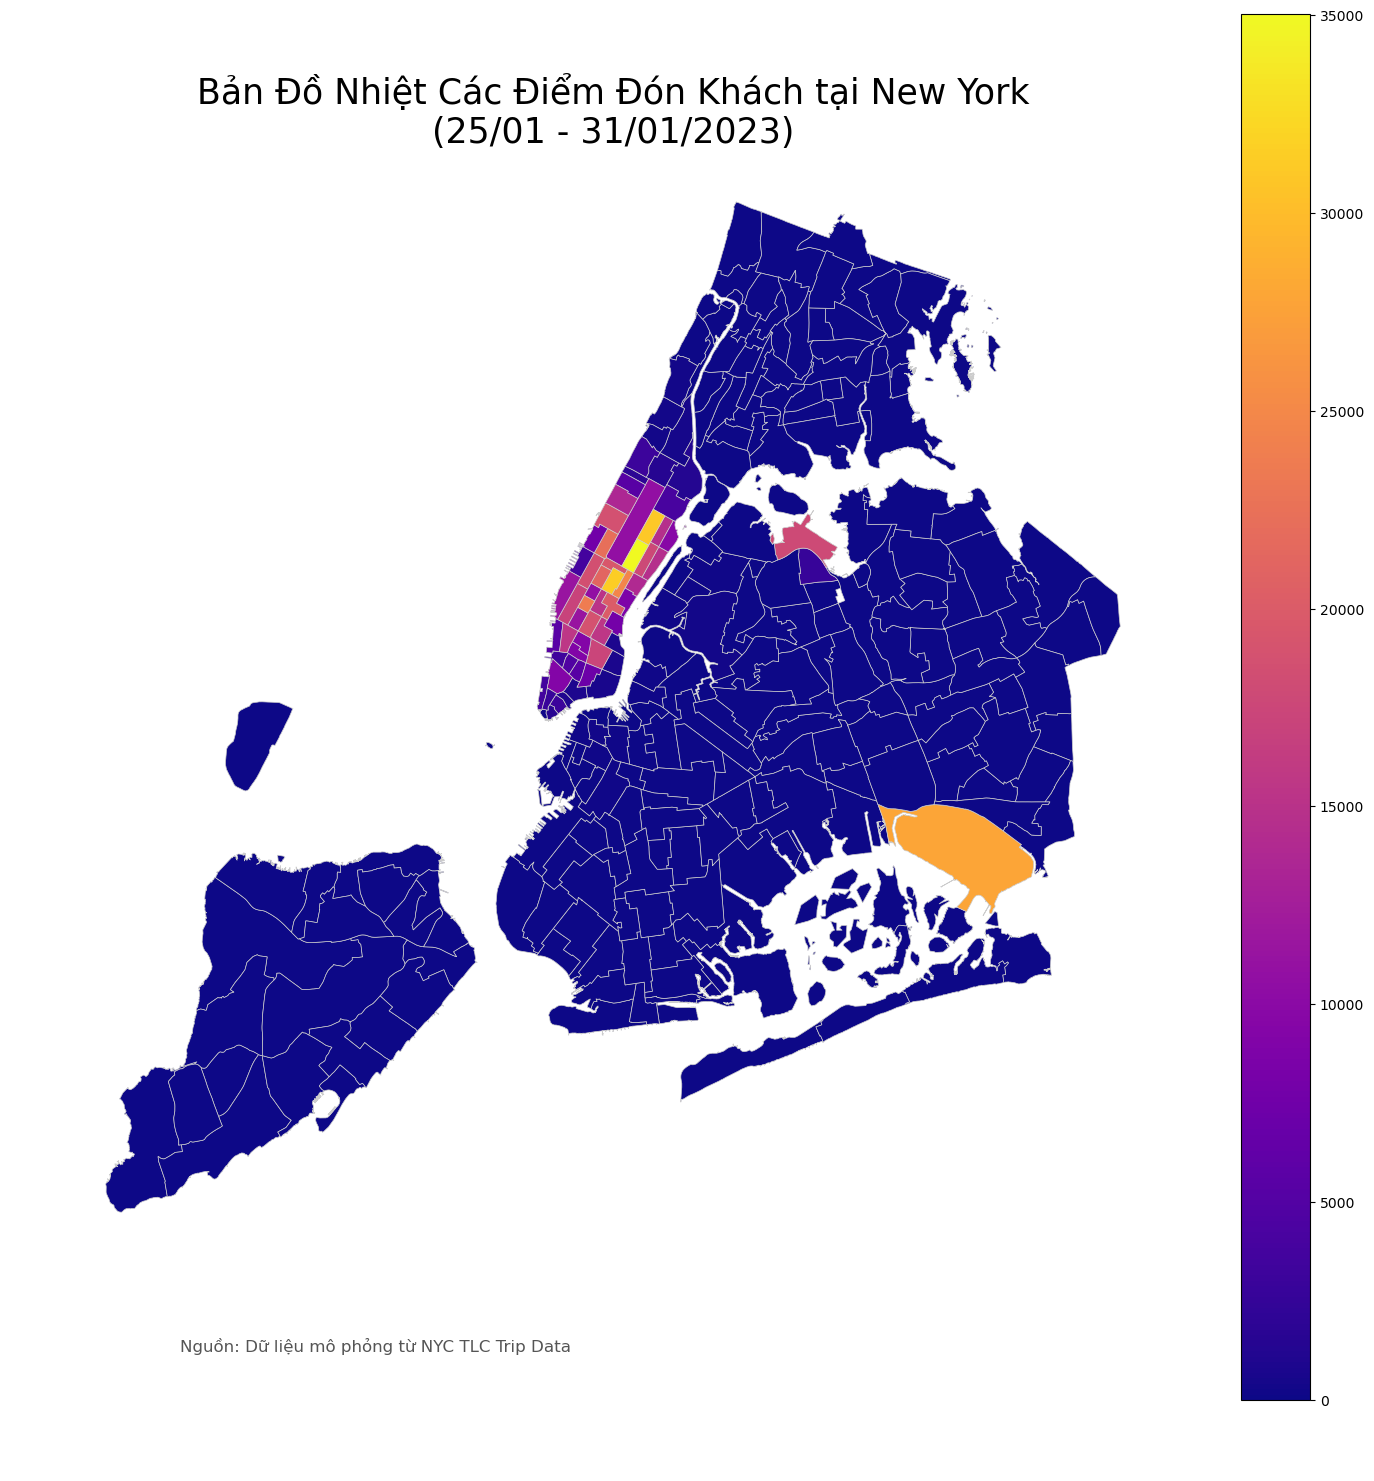

In [10]:
# Cell 13: Vẽ bản đồ Choropleth
if 'merged_gdf' in locals():
    # Thiết lập biểu đồ
    fig, ax = plt.subplots(1, 1, figsize=(18, 18))
    
    # Vẽ bản đồ
    merged_gdf.plot(
        column='pickup_count', # Cột dữ liệu để tô màu
        cmap='plasma',        # Bảng màu (plasma, viridis, inferno, magma)
        linewidth=0.5,        # Độ dày của đường viền khu vực
        ax=ax,
        edgecolor='0.8',      # Màu của đường viền
        legend=True,          # Hiển thị thanh chú giải màu sắc
        missing_kwds={        # Cấu hình cho các khu vực không có dữ liệu (đã fillna(0))
            "color": "lightgrey",
            "label": "Không có chuyến đi",
        }
    )
    
    # Tùy chỉnh biểu đồ
    ax.set_axis_off() # Tắt các trục X, Y không cần thiết
    
    # Thêm tiêu đề
    ax.set_title(
        'Bản Đồ Nhiệt Các Điểm Đón Khách tại New York\n(25/01 - 31/01/2023)', 
        fontdict={'fontsize': '25', 'fontweight': '3'}
    )
    
    # Thêm chú thích nguồn
    ax.annotate(
        'Nguồn: Dữ liệu mô phỏng từ NYC TLC Trip Data',
        xy=(0.1, .08), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=12, color='#555555'
    )
    
    # Điều chỉnh vị trí của thanh chú giải
    legend = ax.get_legend()
    if legend:
        legend.set_title("Số lượng chuyến đi")

    # Hiển thị bản đồ
    plt.show()

### Báo cáo 4: Số lượng đánh giá 1 sao và 2 sao nhận được mỗi ngày trong tuần qua (25/01/2023 - 31/01/2023) là bao nhiêu?

In [11]:
sql_ratings = """
SELECT
    trip_id,
    rating_for_driver
FROM
    trip_feedback
WHERE
    rating_for_driver IN (1, 2);
"""

sql_dates = """
SELECT
    trip_id,
    tpep_pickup_datetime::date AS pickup_date
FROM
    trips
WHERE
    tpep_pickup_datetime::date BETWEEN '2023-01-25' AND '2023-01-31';
"""

In [ ]:
# Cell 13.5 (hoặc một ô mới trước Cell 14): Định nghĩa hàm helper

def get_data_from_db(config, query, description=""):
    """
    Hàm chung để kết nối đến CSDL PostgreSQL và lấy dữ liệu vào Pandas DataFrame.
    
    Args:
        config (dict): Dictionary chứa thông tin kết nối CSDL.
        query (str): Câu lệnh SQL để thực thi.
        description (str): Mô tả ngắn gọn về hành động để in ra màn hình.
        
    Returns:
        pandas.DataFrame: DataFrame chứa kết quả truy vấn, hoặc None nếu có lỗi.
    """
    conn = None
    df = None
    try:
        if description:
            print(f"Đang kết nối đến CSDL '{config['dbname']}' để {description}...")
        else:
            print(f"Đang kết nối đến CSDL '{config['dbname']}'...")
            
        conn = psycopg2.connect(**config)
        
        # Sử dụng pandas để đọc kết quả SQL trực tiếp vào DataFrame
        df = pd.read_sql_query(query, conn)
        
        print(f"Lấy thành công {len(df)} dòng.")
        
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")
        return None # Trả về None nếu có lỗi
    finally:
        if conn:
            conn.close()
            # print(f"Đã đóng kết nối đến '{config['dbname']}'.") # Có thể bỏ comment nếu muốn xem log chi tiết
    return df

In [16]:
# Tải dữ liệu từ CSDL CRM
print("--- Đang tải dữ liệu từ CSDL CRM ---")
df_ratings = get_data_from_db(DB_CONFIG_CRM, sql_ratings, "lấy dữ liệu đánh giá thấp")

# Tải dữ liệu từ CSDL Vận hành
print("\n--- Đang tải dữ liệu từ CSDL Vận hành ---")
df_dates = get_data_from_db(DB_CONFIG_OPERATIONS, sql_dates, "lấy ngày của các chuyến đi")

--- Đang tải dữ liệu từ CSDL CRM ---
Đang kết nối đến CSDL 'Uber_crm_db' để lấy dữ liệu đánh giá thấp...


C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_4296\791571683.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Lấy thành công 23928 dòng.

--- Đang tải dữ liệu từ CSDL Vận hành ---
Đang kết nối đến CSDL 'Uber_operation_DB' để lấy ngày của các chuyến đi...
Lấy thành công 663988 dòng.


In [17]:
if df_ratings is not None and df_dates is not None:
    # Hợp nhất hai DataFrame dựa trên 'trip_id'
    merged_df = pd.merge(df_ratings, df_dates, on='trip_id', how='inner')
    
    # Đếm số lượng đánh giá thấp mỗi ngày
    daily_low_ratings = merged_df.groupby('pickup_date').size().reset_index(name='low_rating_count')
    
    # Sắp xếp lại theo ngày
    daily_low_ratings = daily_low_ratings.sort_values('pickup_date')
    
    print("\nHợp nhất và xử lý dữ liệu thành công.")
    display(daily_low_ratings)
else:
    print("Không thể xử lý do một trong các DataFrame không được tải thành công.")


Hợp nhất và xử lý dữ liệu thành công.


,pickup_date,low_rating_count
0,2023-01-25,847
1,2023-01-26,894
2,2023-01-27,813
3,2023-01-28,830
4,2023-01-29,720
5,2023-01-30,637
6,2023-01-31,827


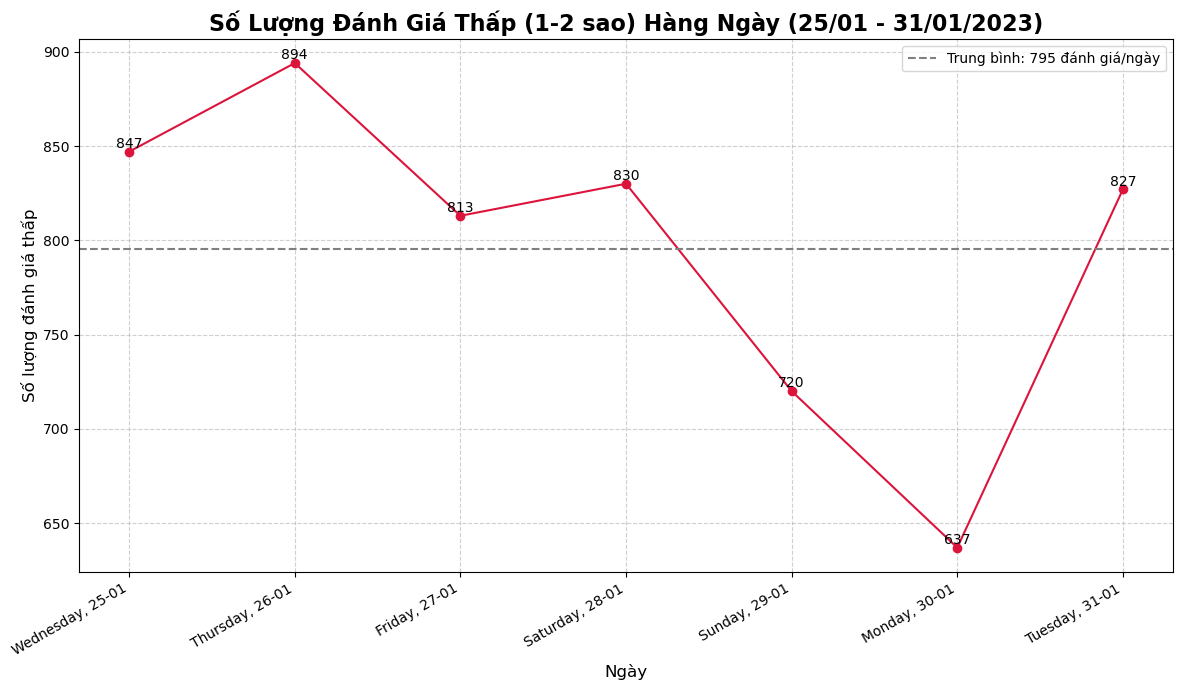

In [18]:
if 'daily_low_ratings' in locals():
    # Chuyển đổi sang kiểu datetime để vẽ biểu đồ cho đúng
    daily_low_ratings['pickup_date'] = pd.to_datetime(daily_low_ratings['pickup_date'])

    # Thiết lập kích thước
    plt.figure(figsize=(12, 7))
    
    # Vẽ biểu đồ đường
    plt.plot(
        daily_low_ratings['pickup_date'], 
        daily_low_ratings['low_rating_count'],
        marker='o',             # Đánh dấu các điểm dữ liệu
        linestyle='-',          # Nối các điểm bằng đường thẳng
        color='crimson'         # Màu đỏ để thể hiện sự cảnh báo
    )
    
    # Thêm số liệu vào các điểm để dễ đọc
    for i, row in daily_low_ratings.iterrows():
        plt.text(row['pickup_date'], row['low_rating_count'] + 2, str(row['low_rating_count']), ha='center')

    # Thiết lập tiêu đề và nhãn
    plt.title('Số Lượng Đánh Giá Thấp (1-2 sao) Hàng Ngày (25/01 - 31/01/2023)', fontsize=16, fontweight='bold')
    plt.xlabel('Ngày', fontsize=12)
    plt.ylabel('Số lượng đánh giá thấp', fontsize=12)
    
    # Định dạng lại trục X để hiển thị ngày tháng đẹp hơn
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A, %d-%m'))
    plt.xticks(rotation=30, ha='right')
    
    # Thêm lưới
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Thêm một đường trung bình để tham chiếu
    avg_low_ratings = daily_low_ratings['low_rating_count'].mean()
    plt.axhline(y=avg_low_ratings, color='gray', linestyle='--', label=f'Trung bình: {avg_low_ratings:.0f} đánh giá/ngày')
    plt.legend()
    
    plt.tight_layout()
    
    # Hiển thị biểu đồ
    plt.show()